# Feedforward network activations
In this notebook we are going to analyze activations in both trained and untrained network. We are going to use the MNIST and Fashion-MNIST datasets. The primary goal of this particular notebook is to find out how does the structure of data change when it is
transformed by a neural network (often to lower dimension). Core aspect of the structure of data we are interested in is its relation to the categories associated with each datapoint. We are thus going to use dimensionality reduction techniques to acquire
low-dimensional embeddings of the activations inside the neural network and inspect properties of these embeddings.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Data

Loading MNIST and FashionMNIST datasets.

In [3]:
from src.dataset_loading import load_MNIST, load_FashionMNIST

Some properties of the MNIST dataset:

In [4]:
training_data, test_data = load_MNIST()

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
print(training_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Number of classes: {len(training_data.classes)}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Number of classes: 10


Some properties of the FashionMNIST dataset:

In [8]:
training_data, test_data = load_FashionMNIST()

In [9]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
print(training_data)
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Number of classes: {len(training_data.classes)}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Number of classes: 10


We can see that both datasets consist of 60 000 training and 10 000 test examples. Each image of either dataset has only a single channel and its dimensions are 28x28. Each example is associated with one of ten labels.

In [12]:
width, height = 28, 28
n_classes = 10
n_examples = 60_000

### Model
The model we are going to be working with.

In [13]:
from src.activations_feedforward.network import NeuralNetwork 

In [14]:
hidden_sizes = [512, 256, 128]

In [15]:
network = NeuralNetwork(width * height, n_classes, hidden_sizes)
network.to(device)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Training
Methods used for training of the neural network.

In [16]:
from src.activations_feedforward.training import train_loop, test_loop

### Embedding quality
In the section devoted to visualizations of activations of the neural network we are going to need some
way of determining the quality of an embedding. In order to do that we introduce 5 metrics which should correlate with quality of the embeddings.

#### Distances between points
One of the ways to assess quality of an embedding is to look at the distances between points. Distances
between points of the same class ($d_s$) should be small, whereas distances between points of different
classes ($d_d$) should be big. Thus we measure the average distance between points (of either same or
different class). This gives us two metrics of embedding quality.

In [17]:
from src.activations_feedforward.metrics import same_diff_average

#### Cluster centroids
We can look at points belonging to the same class as a cluster. We introduce two metrics using
centroids of these clusters: 1) the total distance from points of a class to its centroid ($c_s$) and 2)
the total distance between different centroids ($c_d$).

In [18]:
from src.activations_feedforward.metrics import dist_to_centroid, dist_between_centroids

#### k-nearest neighbors
We can use the k-nearest neighbors algorithm on the embedding to classify examples in the dataset. The
accuracy of k-nn ($acc_{knn}$) should correlate with the quality of the embedding.

In [19]:
from src.activations_feedforward.metrics import knn_evaluate

### Visualizations
Analyzing and visualizing activations of the neural network. Following the helper methods below are analyses for each dataset.

In [20]:
from src.activations_feedforward.embedding import activations_tsne_plot, activations_umap_plot
from src.activations_feedforward.analysis import activations_loop, compute_results, get_activations_labels

#### MNIST

Analysis and visualizations of network activations for the MNIST dataset. We start off by training a neural network (while also retaining its untrained counterpart), whose activations we are going to later analyze.

In [21]:
# Load data
training_data, test_data = load_MNIST()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [22]:
# Initialize network
network = NeuralNetwork(width * height, n_classes, hidden_sizes)
network.to(device)

# Save untrained copy of the network
untrained_state = deepcopy(network.state_dict())
untrained_network = NeuralNetwork(width * height, n_classes, hidden_sizes)
untrained_network.to(device).load_state_dict(untrained_state)

<All keys matched successfully>

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=1e-1, momentum=0.9)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, network, loss_fn, optimizer, device)
    test_loop(test_dataloader, network, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299513  [    0/60000]
loss: 1.003671  [ 6400/60000]
loss: 0.720958  [12800/60000]
loss: 0.504389  [19200/60000]
loss: 0.518798  [25600/60000]
loss: 0.374951  [32000/60000]
loss: 0.583328  [38400/60000]
loss: 0.250201  [44800/60000]
loss: 0.301285  [51200/60000]
loss: 0.320906  [57600/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.362271 

Epoch 2
-------------------------------
loss: 0.340622  [    0/60000]
loss: 0.090006  [ 6400/60000]
loss: 0.086176  [12800/60000]
loss: 0.141132  [19200/60000]
loss: 0.052477  [25600/60000]
loss: 0.105664  [32000/60000]
loss: 0.076297  [38400/60000]
loss: 0.012618  [44800/60000]
loss: 0.005005  [51200/60000]
loss: 0.147926  [57600/60000]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.131803 

Epoch 3
-------------------------------
loss: 0.084552  [    0/60000]
loss: 0.013464  [ 6400/60000]
loss: 0.021476  [12800/60000]
loss: 0.075923  [19200/60000]
loss: 0.028635  [25600/60000]
loss: 0.113471  [32000/600

Having trained the network we can proceed to the analysis of its activations. We start off with the activations in the trained network. For that we need to go through the whole dataset and compute all the activations. Then we are going to apply the t-SNE algorithm to acquire embeddings for activations in each layer (including input layer, that is, the original dataset). Lastly, we are going to compare the embedding quality for each layer.

In [24]:
# We won't need the data to be shuffled anymore
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [25]:
results = dict()

In [26]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 30min 2s, sys: 37.7 s, total: 30min 40s
Wall time: 7min 13s


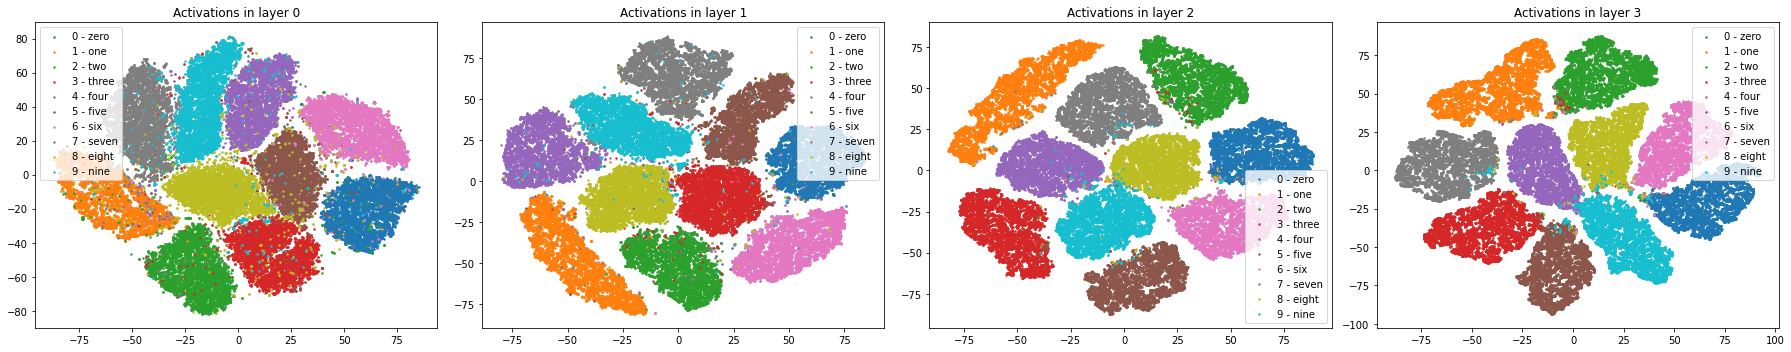

In [27]:
%%time

embeddings = activations_tsne_plot(activations, labels, training_data)

In [28]:
%%time

results[("t-sne", "trained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 19s, sys: 24.8 ms, total: 3min 19s
Wall time: 3min 19s


Now we are going to do the same except we are going to use the untrained network.

In [29]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    untrained_network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 31min 31s, sys: 38.4 s, total: 32min 10s
Wall time: 6min 35s


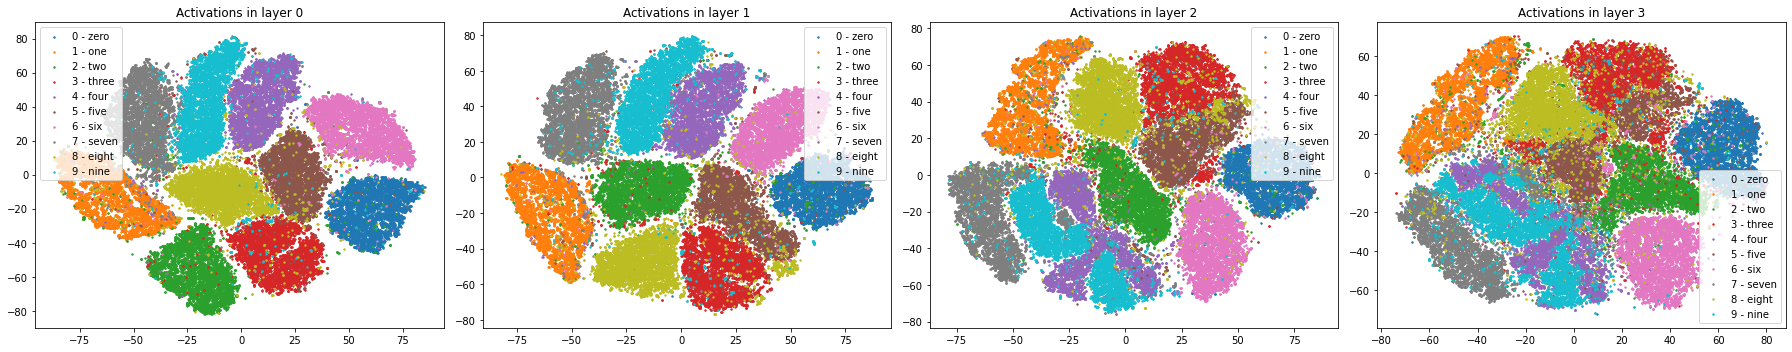

In [30]:
%%time
embeddings = activations_tsne_plot(activations, labels, training_data)

In [31]:
%%time

results[("t-sne", "untrained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 22s, sys: 7.04 ms, total: 3min 22s
Wall time: 3min 23s


Now we can use UMAP in the place of t-SNE. Again, we are going to first compute embeddings on the activations acquired from the network trained on the dataset.

In [32]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 12min 20s, sys: 1min 3s, total: 13min 24s
Wall time: 2min 10s


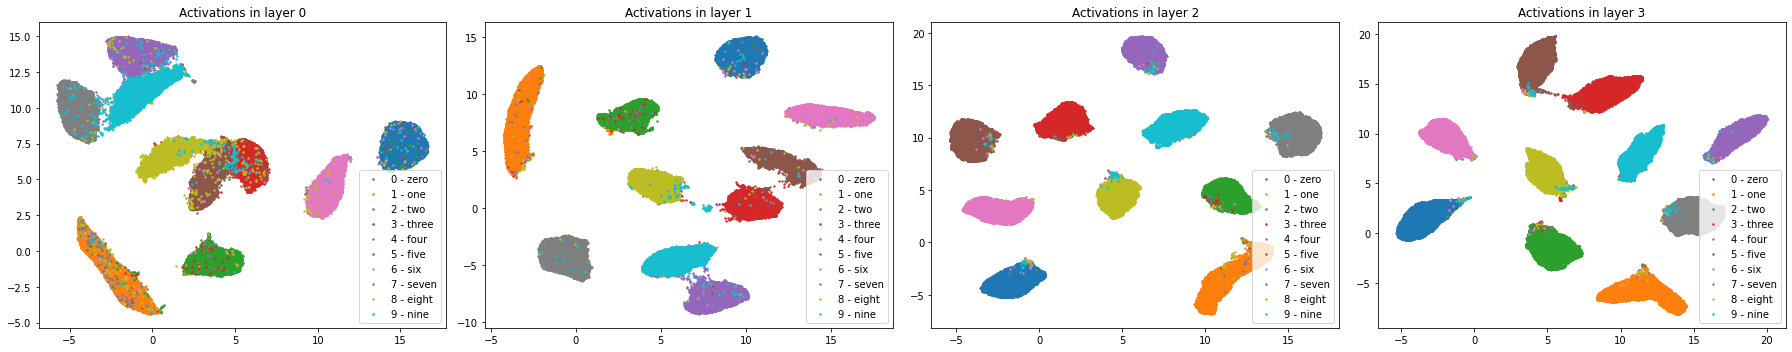

In [33]:
%%time
embeddings = activations_umap_plot(activations, labels, training_data)

In [34]:
%%time

results[("umap", "trained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 42s, sys: 22.9 ms, total: 3min 42s
Wall time: 3min 42s


Again, we are going to do the same except this time for an untrained network.

In [35]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    untrained_network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 7min 6s, sys: 56.9 s, total: 8min 3s
Wall time: 2min 22s


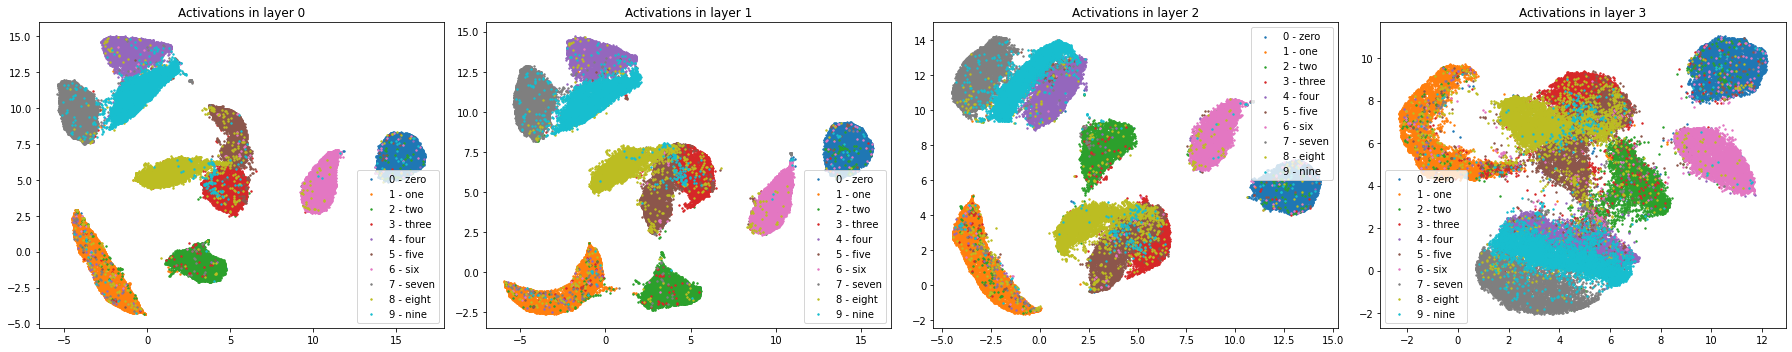

In [36]:
%%time
embeddings = activations_umap_plot(activations, labels, training_data)

In [37]:
%%time

results[("umap", "untrained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 17s, sys: 0 ns, total: 3min 17s
Wall time: 3min 17s


Having computed all the embeddings we can now compare their performance. We will be using the metrics
introduced in the Embedding quality section. First, we are going to inspect the results for t-SNE (first
table) and then the results for UMAP (second table). Each cell of either table contains two values - one
for the trained network and one for the untrained network; this allows us to compare the two.

In [38]:
trained_df = pd.DataFrame(results["t-sne", "trained"])
untrained_df = pd.DataFrame(results["t-sne", "untrained"])

In [39]:
result_df = pd.DataFrame()
result_df["ds"] = trained_df["ds"] + " / " + untrained_df["ds"]
result_df["dd"] = trained_df["dd"] + " / " + untrained_df["dd"]
result_df["cs"] = trained_df["cs"] + " / " + untrained_df["cs"]
result_df["cd"] = trained_df["cd"] + " / " + untrained_df["cd"]
result_df["acc_knn"] = trained_df["acc_knn"] + " / " + untrained_df["acc_knn"]

In [40]:
row_names = ["layer " + str(i) for i in range(4)]
result_df = result_df.rename(dict(zip(result_df.index, row_names)))

Below the table for t-SNE can be found.

In [41]:
result_df

,ds,dd,cs,cd,acc_knn
layer 0,0.3428 / 0.3428,1.0732 / 1.0732,0.2454 / 0.2454,1.0079 / 1.0079,0.9713 / 0.9713
layer 1,0.3191 / 0.3595,1.0759 / 1.0714,0.2301 / 0.2569,1.0266 / 0.9943,0.9862 / 0.9656
layer 2,0.3149 / 0.4077,1.0764 / 1.0660,0.2269 / 0.2919,1.0321 / 0.9642,0.9910 / 0.9493
layer 3,0.3149 / 0.4553,1.0764 / 1.0607,0.2287 / 0.3263,1.0341 / 0.9269,0.9910 / 0.9126


In [42]:
trained_df = pd.DataFrame(results["umap", "trained"])
untrained_df = pd.DataFrame(results["umap", "untrained"])

In [43]:
result_df = pd.DataFrame()
result_df["ds"] = trained_df["ds"] + " / " + untrained_df["ds"]
result_df["dd"] = trained_df["dd"] + " / " + untrained_df["dd"]
result_df["cs"] = trained_df["cs"] + " / " + untrained_df["cs"]
result_df["cd"] = trained_df["cd"] + " / " + untrained_df["cd"]
result_df["acc_knn"] = trained_df["acc_knn"] + " / " + untrained_df["acc_knn"]

In [44]:
row_names = ["layer " + str(i) for i in range(4)]
result_df = result_df.rename(dict(zip(result_df.index, row_names)))

Below the table for UMAP can be found.

In [45]:
result_df

,ds,dd,cs,cd,acc_knn
layer 0,0.2145 / 0.2127,1.0875 / 1.0877,0.1496 / 0.1483,1.0427 / 1.0469,0.9682 / 0.9689
layer 1,0.1799 / 0.2262,1.0914 / 1.0862,0.1265 / 0.1584,1.0641 / 1.0370,0.9853 / 0.9602
layer 2,0.1561 / 0.2667,1.0941 / 1.0817,0.1105 / 0.1867,1.0768 / 1.0161,0.9904 / 0.9278
layer 3,0.1702 / 0.3538,1.0925 / 1.0720,0.1218 / 0.2499,1.0758 / 0.9755,0.9900 / 0.8725


We can see that that the depth at which activations were acquired correlates with quality of corresponding embedding. We can also see that embeddings acquired from trained network tend to have better properties than embeddings acquired from untrained network.
In the first case the correlation is not very profound; in the second case the difference between quality of embeddings is bigger.

#### FashionMNIST

Analysis and visualizations of network activations for the FashionMNIST dataset. We start off by training a neural network (while also retaining its untrained counterpart), whose activations we are going to later analyze.

In [46]:
# Load data
training_data, test_data = load_FashionMNIST()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [47]:
# Initialize network
network = NeuralNetwork(width * height, n_classes, hidden_sizes)
network.to(device)

# Save untrained copy of the network
untrained_state = deepcopy(network.state_dict())
untrained_network = NeuralNetwork(width * height, n_classes, hidden_sizes)
untrained_network.to(device).load_state_dict(untrained_state)

<All keys matched successfully>

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=5e-2, momentum=0.9)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, network, loss_fn, optimizer, device)
    test_loop(test_dataloader, network, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308679  [    0/60000]
loss: 1.557078  [ 6400/60000]
loss: 1.201892  [12800/60000]
loss: 1.670808  [19200/60000]
loss: 1.586796  [25600/60000]
loss: 1.118157  [32000/60000]
loss: 1.291149  [38400/60000]
loss: 1.035294  [44800/60000]
loss: 1.174895  [51200/60000]
loss: 1.133089  [57600/60000]
Test Error: 
 Accuracy: 57.3%, Avg loss: 1.135894 

Epoch 2
-------------------------------
loss: 0.984343  [    0/60000]
loss: 1.010298  [ 6400/60000]
loss: 1.151594  [12800/60000]
loss: 1.301200  [19200/60000]
loss: 0.965924  [25600/60000]
loss: 1.065991  [32000/60000]
loss: 0.990052  [38400/60000]
loss: 1.016670  [44800/60000]
loss: 1.001248  [51200/60000]
loss: 1.173966  [57600/60000]
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.074164 

Epoch 3
-------------------------------
loss: 1.067803  [    0/60000]
loss: 0.925867  [ 6400/60000]
loss: 1.024930  [12800/60000]
loss: 0.999275  [19200/60000]
loss: 0.954476  [25600/60000]
loss: 1.117138  [32000/600

Having trained the network we can proceed to the analysis of its activations. We start off with the activations in the trained network. For that we need to go through the whole dataset and compute all the activations. Then we are going to apply the t-SNE algorithm to acquire embeddings for activations in each layer (including input layer, that is, the original dataset). Lastly, we are going to compare the embedding quality for each layer.

In [49]:
# We won't need the data to be shuffled anymore
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [50]:
results = dict()

In [51]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 27min 58s, sys: 31.1 s, total: 28min 29s
Wall time: 6min 31s


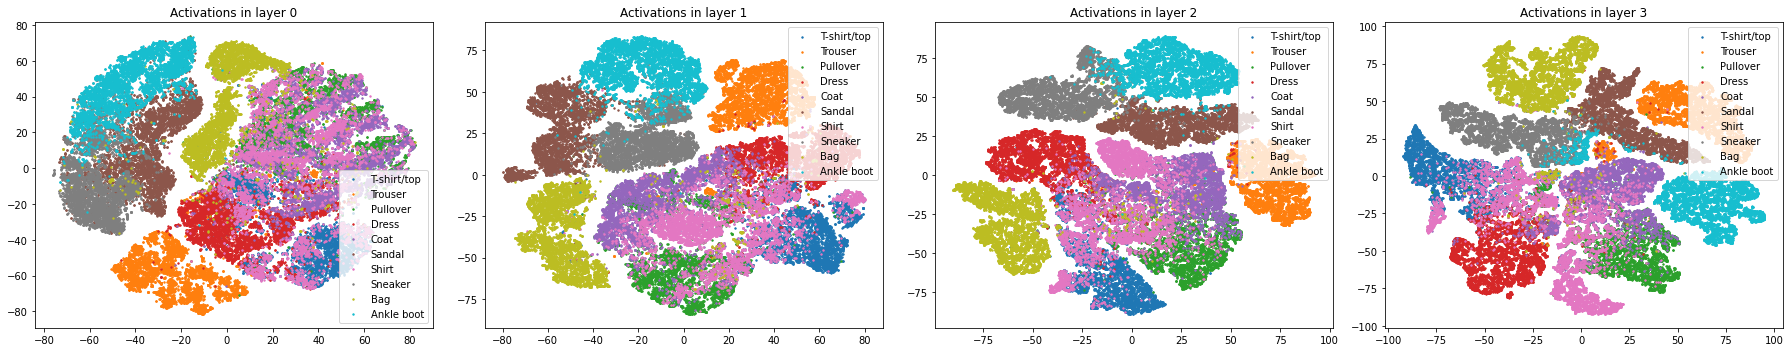

In [52]:
%%time

embeddings = activations_tsne_plot(activations, labels, training_data)

In [53]:
%%time

results[("t-sne", "trained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 32s, sys: 26.1 ms, total: 3min 32s
Wall time: 3min 33s


Now we are going to do the same except we are going to use the untrained network.

In [54]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    untrained_network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 32min 57s, sys: 36 s, total: 33min 33s
Wall time: 10min 52s


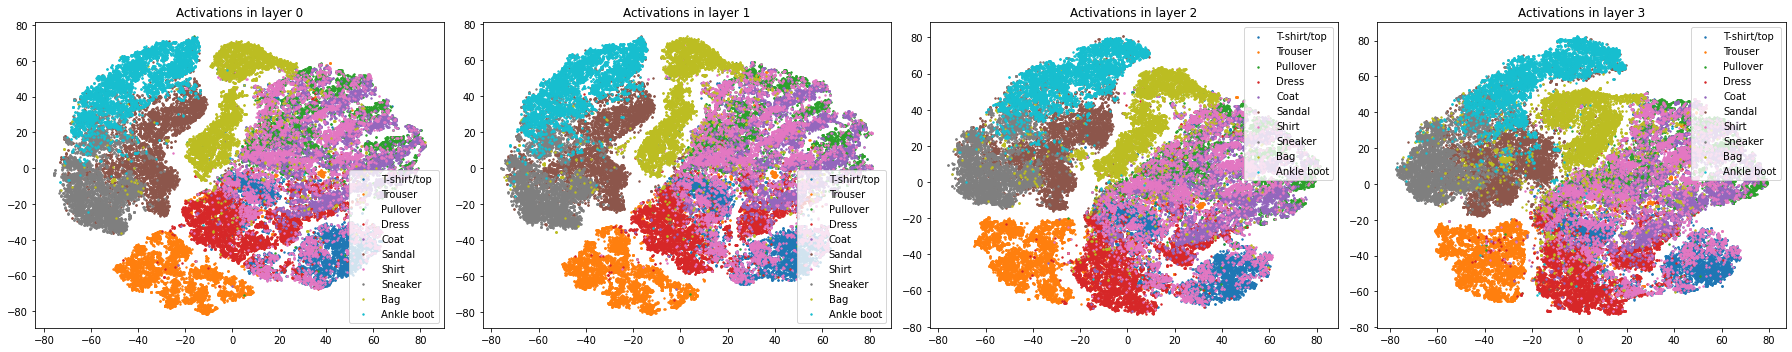

In [55]:
%%time
embeddings = activations_tsne_plot(activations, labels, training_data)

In [56]:
%%time

results[("t-sne", "untrained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 25s, sys: 0 ns, total: 3min 25s
Wall time: 3min 26s


Now we can use UMAP in the place of t-SNE. Again, we are going to first compute embeddings on the activations acquired from the network trained on the dataset.

In [57]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 12min 6s, sys: 1min 11s, total: 13min 17s
Wall time: 2min


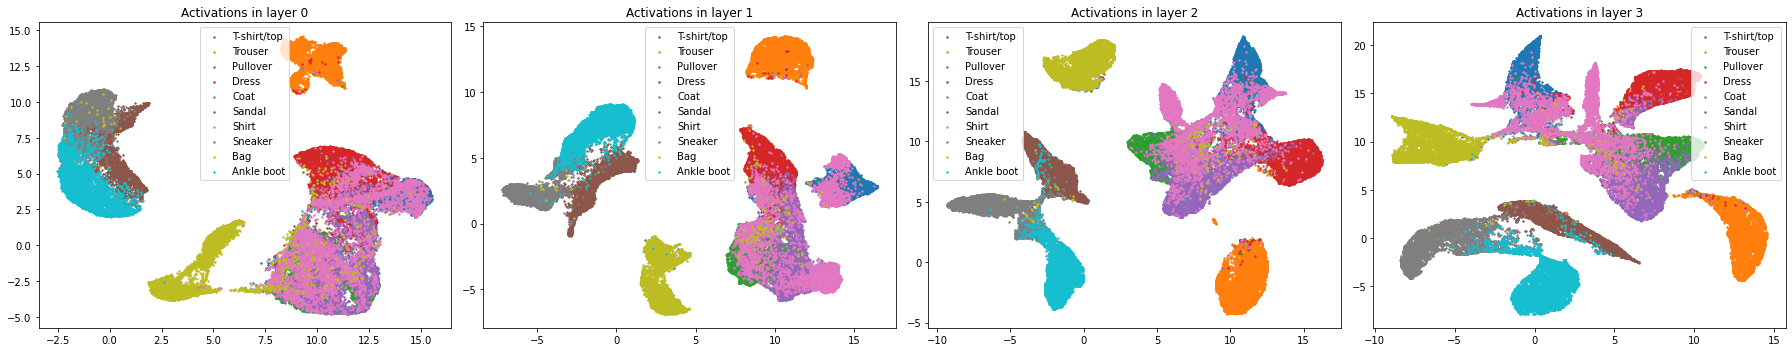

In [58]:
%%time
embeddings = activations_umap_plot(activations, labels, training_data)

In [59]:
%%time

results[("umap", "trained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 35s, sys: 0 ns, total: 3min 35s
Wall time: 3min 36s


Again, we are going to do the same except this time for an untrained network.

In [60]:
activations, labels = get_activations_labels(
    n_examples,
    width,
    height,
    hidden_sizes,
    train_dataloader,
    untrained_network,
    device
)

Learning embeddings for layer 0...
Learning embeddings for layer 1...
Learning embeddings for layer 2...
Learning embeddings for layer 3...
CPU times: user 10min 12s, sys: 39.9 s, total: 10min 52s
Wall time: 1min 41s


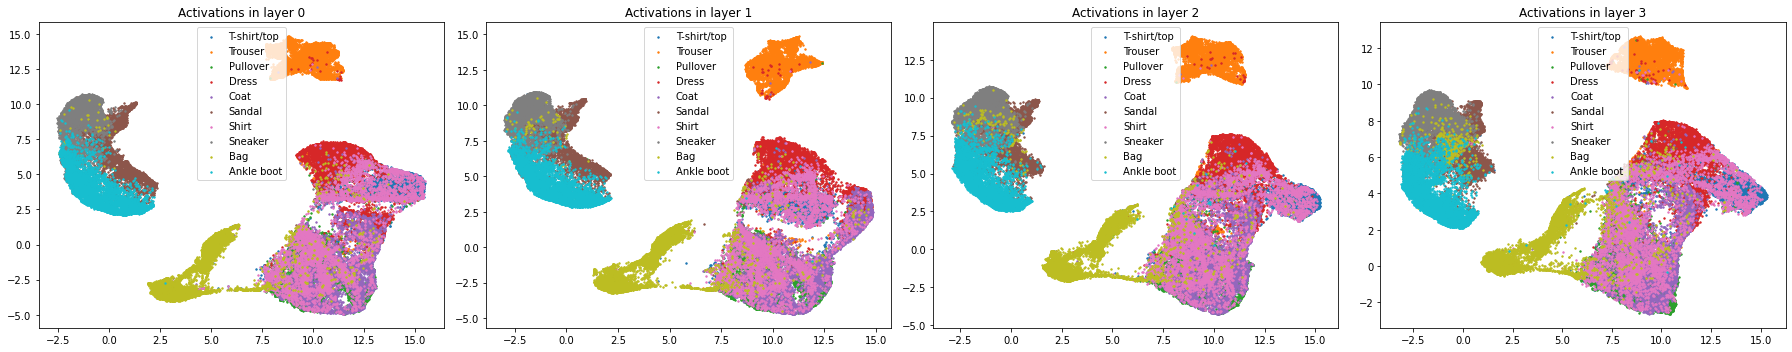

In [61]:
%%time
embeddings = activations_umap_plot(activations, labels, training_data)

In [62]:
%%time

results[("umap", "untrained")] = compute_results(embeddings, labels, training_data)

CPU times: user 3min 13s, sys: 0 ns, total: 3min 13s
Wall time: 3min 13s


Having computed all the embeddings we can now compare their performance. We will be using the metrics
introduced in the Embedding quality section. First, we are going to inspect the results for t-SNE (first
table) and then the results for UMAP (second table). Each cell of either table contains two values - one
for the trained network and one for the untrained network; this allows us to compare the two.

In [63]:
trained_df = pd.DataFrame(results["t-sne", "trained"])
untrained_df = pd.DataFrame(results["t-sne", "untrained"])

In [64]:
result_df = pd.DataFrame()
result_df["ds"] = trained_df["ds"] + " / " + untrained_df["ds"]
result_df["dd"] = trained_df["dd"] + " / " + untrained_df["dd"]
result_df["cs"] = trained_df["cs"] + " / " + untrained_df["cs"]
result_df["cd"] = trained_df["cd"] + " / " + untrained_df["cd"]
result_df["acc_knn"] = trained_df["acc_knn"] + " / " + untrained_df["acc_knn"]

In [65]:
row_names = ["layer " + str(i) for i in range(4)]
result_df = result_df.rename(dict(zip(result_df.index, row_names)))

Below the table for t-SNE can be found.

In [66]:
result_df

,ds,dd,cs,cd,acc_knn
layer 0,0.4659 / 0.4659,1.0593 / 1.0593,0.3439 / 0.3439,0.9407 / 0.9407,0.8644 / 0.8644
layer 1,0.3896 / 0.4666,1.0678 / 1.0593,0.2833 / 0.3445,0.9949 / 0.9417,0.9034 / 0.8589
layer 2,0.3856 / 0.4638,1.0683 / 1.0596,0.2811 / 0.3404,0.9960 / 0.9432,0.9049 / 0.8496
layer 3,0.4164 / 0.4750,1.0648 / 1.0583,0.3022 / 0.3475,0.9769 / 0.9332,0.9033 / 0.8308


In [67]:
trained_df = pd.DataFrame(results["umap", "trained"])
untrained_df = pd.DataFrame(results["umap", "untrained"])

In [68]:
result_df = pd.DataFrame()
result_df["ds"] = trained_df["ds"] + " / " + untrained_df["ds"]
result_df["dd"] = trained_df["dd"] + " / " + untrained_df["dd"]
result_df["cs"] = trained_df["cs"] + " / " + untrained_df["cs"]
result_df["cd"] = trained_df["cd"] + " / " + untrained_df["cd"]
result_df["acc_knn"] = trained_df["acc_knn"] + " / " + untrained_df["acc_knn"]

In [69]:
row_names = ["layer " + str(i) for i in range(4)]
result_df = result_df.rename(dict(zip(result_df.index, row_names)))

Below the table for UMAP can be found.

In [70]:
result_df

,ds,dd,cs,cd,acc_knn
layer 0,0.2993 / 0.3000,1.0778 / 1.0778,0.2192 / 0.2211,1.0207 / 1.0192,0.8108 / 0.8150
layer 1,0.2669 / 0.3035,1.0814 / 1.0774,0.1971 / 0.2208,1.0348 / 1.0182,0.8881 / 0.8101
layer 2,0.2523 / 0.3111,1.0831 / 1.0765,0.1805 / 0.2277,1.0497 / 1.0144,0.8989 / 0.7911
layer 3,0.2933 / 0.3392,1.0785 / 1.0734,0.2099 / 0.2475,1.0354 / 0.9994,0.8999 / 0.7705


We can observe very similar pattern as in the case of the MNIST dataset. However, the differences between layers and even the differences between trained and untrained network seem to be smaller.

### Conclusions
We have trained neural networks on two datasets and analyzed their activations: first, we compared activations between different layers of the same network, then we compared activations in the same layer between trained and untrained network. The analysis was
based on 5 metrics of embedding quality. Both in the MNIST and FashionMNIST dataset we observed a trend of increasing quality of embeddings when activations were taken from bigger depth and when activations of trained network were used. However, the effects were
rather weak, especially in the case of FashionMNIST.

Based on the results we might hypothesize that the network might have been unnecesarily deep for the given task. We base this upon the fact that in most of the metrics of embedding quality a big improvement can be observed after a single layer, but later layers
seem to bring only diminishing returns.

In the subsequent work it might be a good idea to do cross-validation over the whole dataset to acquire confidence bounds on the values of metrics. It would also make sense to use a more suitable neural network architecture for the task, in particular Convolutional
neural network. Lastly, experiments using several neural networks with different structure could help us understand what effects would changing the depth or width have on the quality of the embeddings.